# alright outgrown this notebook, time to oop this mess

In [2]:
import re
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from typing import List
from collections import namedtuple
from enum import Enum
import zipfile
import zlib
import drawsvg as dw
from drawsvg import FrameAnimation
import os
import numpy as np
os.environ['PATH']+=";c:\\Users\\picokatx\\Documents\\twipFR\\bin"

In [3]:
BASE_DIR = "assets/base/LIBRARY/PonyTemplate►/PonyTemplate►BodyParts/PonyTemplate►Wings/"

In [4]:
class DrawCommand(Enum):
    MOVETO = 0
    LINETO = 1
    QUADRATICTO = 2
Edge = namedtuple("Edge", ["type", "data", "S"])
Path = namedtuple("Path", ["edges", "stroke", "fill0", "fill1"])
Shape = namedtuple("Shape", ["palette","transformation_pt", "trans_mat", "paths"])
Point = namedtuple("Point", ["x", "y"])
StrokeStyle = namedtuple("Stroke", ["color", "scaleMode", "caps", "weight", "joints", "miterLimit"])


def xml_find_prepend(root: Element, path: List[str]):
    return root.find("/".join(".//{http://ns.adobe.com/xfl/2008/}"+p for p in path))
def xml_findall_prepend(root: Element, path: List[str]):
    return root.findall("/".join(".//{http://ns.adobe.com/xfl/2008/}"+p for p in path))
SYMBOLS = [
    r"\s*\!(-*\d+\.*\d*)\s+(-*\d+\.*\d*)\s*",
    r"\s*\|(-*\d+\.*\d*)\s+(-*\d+\.*\d*)\s*",
    r"\s*\[((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s*",
    r"S\d{1}"
]

def decode_fla_value(val: str):
    if val[0]=="#":
        if len(val[1:].split(".")[1])==1: val = val[0]+"."+val[1:]+"0"
        hex_out = "".join(val[1:].split("."))
        out = int(hex_out, 16)
        if out >= 0x80000000:
            out = -(0xffffffff - out + 1)
        out = out / 256
    else:
        out = float(val) if "." in val else int(val)
    if (out>100000): print(val, out)
    return out / 20

def transform_point(x, y, matrix):
    point = np.array([x, y, 1])
    transformed_point = matrix @ point
    return [transformed_point[0], transformed_point[1]]

def pathstring_parse(pathstr: str, S: int, transformation_matrix: np.ndarray):
    c = 0
    code = []
    edge = pathstr
    prev_pos = None
    while c<len(edge):
        found_symbol = False
        for i in range(len(SYMBOLS)):
            out = re.match(SYMBOLS[i], edge[c:])
            if (out!=None):
                found_symbol = True
                if i!=3:
                    args = [decode_fla_value(c) for c in out.groups()]
                    if prev_pos!=args[-2:] or i!=0:
                        code.append(Edge(DrawCommand(i), args, S))
                    prev_pos = args[-2:]
                else:
                    S = int(out.group(0)[1])
                c+=out.span()[1]-out.span()[0]
                break
        if not found_symbol:
            print(edge[c:c+50])
            break
    return S, code

def DOMshape_parse(elm: Element):
    trans_pt_node = xml_find_prepend(elm, ["transformationPoint"])
    trans_pt = xml_find_prepend(trans_pt_node, ["Point"]) if trans_pt_node!=None else None
    trans_coords = Point(trans_pt.attrib['x'], trans_pt.attrib['y']) if trans_pt!=None else (-1, -1)
    
    # matrix
    matrix = xml_find_prepend(elm, ["matrix/"])
    transformation_matrix = None
    if matrix!=None:
        matargs = matrix.attrib
        a = matargs['a'] if 'a' in matargs else 1
        b = matargs['b'] if 'b' in matargs else 0
        c = matargs['c'] if 'c' in matargs else 0
        d = matargs['d'] if 'd' in matargs else 1
        tx = matargs['tx'] if 'tx' in matargs else 0
        ty = matargs['ty'] if 'ty' in matargs else 0

        transformation_matrix = np.array([
            [a, c, tx],
            [b, d, ty],
            [0, 0, 1]
        ], dtype=np.float64)

    # color palette
    fills = xml_findall_prepend(elm, ["fills/"])
    fill_dict = {0: None}
    for fill in fills:
        fill_dict[fill.attrib["index"]] = xml_find_prepend(fill, ["SolidColor"]).attrib["color"]

    # stroke
    strokes = xml_findall_prepend(elm, ["strokes/"])
    stroke_dict = {0: None}
    if strokes!=None:
        for stroke in strokes:
            temp = xml_find_prepend(stroke, ["SolidStroke"])
            stroke_dict[stroke.attrib["index"]] = StrokeStyle(
                color=xml_find_prepend(temp, ["fill/"]).attrib["color"],
                scaleMode=temp.attrib["scaleMode"],
                caps=temp.attrib["caps"],
                weight=temp.attrib["weight"],
                joints=temp.attrib["joints"],
                miterLimit=temp.attrib["miterLimit"]
            )
    # paths
    edges = xml_findall_prepend(elm, ["edges/"])
    paths = []
    hints = [] # not using hints cubics for now
    S = 0
    for edge in edges:
        if "edges" in edge.attrib:
            fill0 = fill_dict[edge.attrib["fillStyle0"] if "fillStyle0" in edge.attrib else 0]
            fill1 = fill_dict[edge.attrib["fillStyle1"] if "fillStyle1" in edge.attrib else 0]
            stroke_col = stroke_dict[edge.attrib["strokeStyle"] if "strokeStyle" in edge.attrib else 0]
            S, temp = pathstring_parse(edge.attrib["edges"].replace("\n", "").strip(), S, transformation_matrix)
            paths.append(Path(temp, stroke_col, fill0, fill1))
        else:
            hints.append(edge.attrib["cubics"])
    return Shape(fill_dict, trans_coords, transformation_matrix, paths)
    


In [5]:
def get_startpt(path: Path):
    return path.edges[0].data
def get_endpt(path: Path):
    if path.edges[-1].type == DrawCommand.QUADRATICTO:
        return path.edges[-1].data[2:]
    else:
        return path.edges[-1].data
def closed(path: Path):
    return get_startpt(path)==get_endpt(path)
def get_pt(edge):
    if edge.type == DrawCommand.MOVETO:
        return edge.data
    if edge.type == DrawCommand.LINETO:
        return edge.data
    if edge.type == DrawCommand.QUADRATICTO:
        return edge.data[2:]
def get_quad(edge):
    if edge.type == DrawCommand.MOVETO:
        return None
    if edge.type == DrawCommand.LINETO:
        return None
    if edge.type == DrawCommand.QUADRATICTO:
        return edge.data[:2]
def path_join(path1: Path, path2: Path):
    if get_endpt(path1)==get_startpt(path2):
        return Path(path1.edges+path2.edges[1:], path1.stroke, path1.fill0, path1.fill1)
    else:
        return None
def disjoint_path_join(path1: Path, path2: Path):
    return Path(path1.edges+path2.edges, path1.stroke, path1.fill0, path1.fill1)
def reverse_draw_commands(path: Path):
    edges = path.edges
    reversed_edges = [Edge(DrawCommand.MOVETO, get_pt(edges[-1]), edges[-1].S)]
    prev_quad = None
    prev_command = None
    endpt = get_pt(edges[-1])
    for edge in reversed(edges):
        endpt = get_pt(edge)
        if prev_command == DrawCommand.MOVETO:
            reversed_edges.append(Edge(DrawCommand.MOVETO, endpt, edge.S))
        elif prev_command == DrawCommand.LINETO:
            reversed_edges.append(Edge(DrawCommand.LINETO, endpt, edge.S))
        elif prev_command == DrawCommand.QUADRATICTO:
            reversed_edges.append(Edge(DrawCommand.QUADRATICTO, prev_quad+endpt, edge.S))
        prev_command = edge.type
        prev_quad = get_quad(edge)
    return Path(reversed_edges, path.stroke, path.fill1, path.fill0)


In [21]:
def addEdgeToGroup(edgeGroups,group,edge):
    if not group in edgeGroups: edgeGroups[group] = []
    edgeGroups[group].append(edge)

def findConnectedTo(prevEdge,edges):
    for i, edge in enumerate(edges):
        if get_startpt(edge) == get_endpt(prevEdge): return i, 1
        if get_endpt(edge) == get_startpt(prevEdge): return i, 2
    return -1, 0
# print(fill, contour.fill0, contour.fill1, group[at].fill0, group[at].fill1)

def findContour(group: List[Path], fill):
    contour = group.pop(0)
    at, which = findConnectedTo(contour,group)
    while ((not closed(contour)) and len(group) > 0 and at != -1): # at != -1 is wrong, but temporary just to make error go away
        contour = path_join(contour, group[at]) if which==1 else path_join(group[at], contour)
        group.pop(at)
        at, which = findConnectedTo(contour,group)
    return contour

def findContours(group: List[Path], fill):
    group = [path for path in group]
    contours = []
    while len(group) > 0:
        contours.append(findContour(group, fill))
    return contours

def find_subpaths(path: Path):
    paths = []
    start_pt = None
    old_i = 0
    for i, edge in enumerate(path.edges):
        end_pt = get_pt(edge)
        if end_pt==[-7.0, 99.85]: print(i, edge, path)
        if start_pt==None:
            start_pt = get_pt(edge)
        elif end_pt==start_pt: #  or (edge.type==DrawCommand.MOVETO and i!=0)
            offset = i+1
            # if (edge.type==DrawCommand.MOVETO and i!=0): offset+=1
            paths.append(Path(path.edges[old_i:offset], path.stroke, path.fill0, path.fill1))
            old_i = offset
            start_pt = None
    if old_i!=i+1: paths.append(Path(path.edges[old_i:i+1], path.stroke, path.fill0, path.fill1))
    return paths

def draw_path(path: Path):
    d = dw.Drawing(480, 480, id_prefix='pic', origin=(-240, -240))
    stroke = path.stroke if path.stroke!=None else StrokeStyle(None, None, None, 0, None, None)
    tracer = dw.Path(fill='white', stroke="blue", stroke_width=3, stroke_linecap="butt", stroke_linejoin=stroke.joints, stroke_miterlimit=stroke.miterLimit, transform=None)
    for edge in path.edges:
        if edge.type==DrawCommand.MOVETO:
            tracer.M(edge.data[0], edge.data[1])
        if edge.type==DrawCommand.LINETO:
            tracer.L(edge.data[0], edge.data[1])
        if edge.type==DrawCommand.QUADRATICTO:
            tracer.Q(edge.data[0], edge.data[1], edge.data[2], edge.data[3])
    d.append(tracer)
    return d
def draw_paths(paths: List[Path]):
    d = dw.Drawing(480, 480, id_prefix='pic', origin=(-240, -240))
    for path in paths:
        stroke = path.stroke if path.stroke!=None else StrokeStyle(None, None, None, 0, None, None)
        tracer = dw.Path(fill='grey', stroke="blue", stroke_width=3, stroke_linecap="butt", stroke_linejoin=stroke.joints, stroke_miterlimit=stroke.miterLimit, transform=None)
        for edge in path.edges:
            if edge.type==DrawCommand.MOVETO:
                tracer.M(edge.data[0], edge.data[1])
            if edge.type==DrawCommand.LINETO:
                tracer.L(edge.data[0], edge.data[1])
            if edge.type==DrawCommand.QUADRATICTO:
                tracer.Q(edge.data[0], edge.data[1], edge.data[2], edge.data[3])
        d.append(tracer)
    return d
def crop_path(path: Path, start: int, end: int):
    return Path(path.edges[start:end], path.stroke, path.fill0, path.fill1)

In [7]:
# issue is we are not checking for contours within a path, need to add code that does that
# also don't forget alpha support
# order here changes things, figure out why
# ok so two paths with different fills are joined, how to deal with this?
# 3 paths are connected by the same point. 1 has both fills, 2 have one fill each shared with the 1st.

In [38]:
i = -1

In [42]:
i+=1
draw_path(animations[2][3][0].paths[i])


IndexError: list index out of range

In [47]:
animations[2][3]

[Shape(palette={0: None, '1': '#666666', '2': '#CCCCCC'}, transformation_pt=Point(x='5.35', y='106'), trans_mat=None, paths=[Path(edges=[Edge(type=<DrawCommand.MOVETO: 0>, data=[-41.5, 174.85], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-41.6, 175.4, -41.4, 175.4], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-28.65, 177.0, -14.9, 173.95], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-8.95, 172.65, -4.3, 171.05], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[0.8, 169.05, 4.95, 166.4], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[13.35, 161.0, 16.3, 154.8], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[19.3, 148.75, 16.65, 144.15], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[18.25, 143.2, 19.9, 142.15], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[22.9, 140.2, 27.7, 136.4], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[36.35, 129.45, 43.45, 121.35], S=1), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[50.8, 112.75, 54.0, 105.

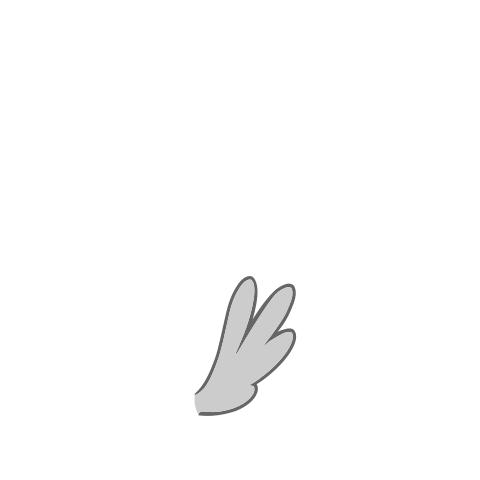

In [22]:
root  = ET.parse(BASE_DIR+"PonyTemplate►3Q Front Wing.xml").getroot()
layers = xml_find_prepend(root, ["timeline", "DOMTimeline", "layers"])
animations = []
for layer in layers:
    frames = xml_findall_prepend(layer, ["frames/"])
    anim_frames = []
    for frame in frames:
        shapes = []
        elements = xml_findall_prepend(frame, ["elements/"])
        for element in elements:
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMShape":
                shapes.append(DOMshape_parse(element))
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMGroup":
                for member in xml_findall_prepend(element, ["DOMShape"]):
                    shapes.append(DOMshape_parse(member))
        anim_frames.append(shapes)
    animations.append(anim_frames)

OFFSET = 240
SIZE = 480
d = dw.Drawing(SIZE, SIZE, id_prefix='pic', origin=(-OFFSET, -OFFSET))
shape = animations[2][3][0]
edgeGroups = {}
split_paths = []
for path in shape.paths:
    split_paths.extend(find_subpaths(path))

for path in split_paths: # split_paths[2:6]+split_paths[0:1]
    if path.fill0 != None: addEdgeToGroup(edgeGroups, path.fill0,  path)
    if path.fill1 != None: addEdgeToGroup(edgeGroups, path.fill1, reverse_draw_commands(path))
# print(edgeGroups)
filledRegs = {}
for fillStyle, group in edgeGroups.items():
    filledRegs[fillStyle] = findContours(group, fillStyle)

for fillStyle, group in filledRegs.items():
    # need to merge fills down to single path
    a = findContours([path for path in group], fillStyle)
    ret = a[0]
    for i in range(1, len(a)):
        ret = disjoint_path_join(ret, a[i])
    filledRegs[fillStyle] = [ret]

# print(filledRegs)
for fillCol, contours in filledRegs.items():
    for contour in contours:
        transform = None
        if type(shape.trans_mat)==np.ndarray:
            tm = shape.trans_mat
            tm_a = tm[0][0]
            tm_b = tm[1][0]
            tm_c = tm[0][1]
            tm_d = tm[1][1]
            tm_tx = tm[0][2]
            tm_ty = tm[1][2]
            transform = f"matrix({tm_a} {tm_b} {tm_c} {tm_d} {tm_tx} {tm_ty})"
        stroke = contour.stroke if contour.stroke!=None else StrokeStyle(None, None, None, 0, None, None)
        tracer = dw.Path(fill=fillCol, stroke=stroke.color, stroke_width=stroke.weight, stroke_linecap="butt", stroke_linejoin=stroke.joints, stroke_miterlimit=stroke.miterLimit, transform=transform)
        for edge in contour.edges:
            if edge.type==DrawCommand.MOVETO:
                tracer.M(edge.data[0], edge.data[1])
            if edge.type==DrawCommand.LINETO:
                tracer.L(edge.data[0], edge.data[1])
            if edge.type==DrawCommand.QUADRATICTO:
                tracer.Q(edge.data[0], edge.data[1], edge.data[2], edge.data[3])
        d.append(tracer)
d


In [10]:
d.

drawsvg.drawing.Drawing

In [ ]:
# PonyTemplate►3Q Front Wing.xml 8 frames has bugged triangle thing
# PonyTemplate►Front 3Q Back Wing.xml has something forgot what was wrong

In [11]:
root  = ET.parse(BASE_DIR+"PonyTemplate►Side Wing Front.xml").getroot()
layers = xml_find_prepend(root, ["timeline", "DOMTimeline", "layers"])
animations = []
for layer in layers:
    frames = xml_findall_prepend(layer, ["frames/"])
    anim_frames = []
    for frame in frames:
        shapes = []
        elements = xml_findall_prepend(frame, ["elements/"])
        for element in elements:
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMShape":
                shapes.append(DOMshape_parse(element))
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMGroup":
                for member in xml_findall_prepend(element, ["DOMShape"]):
                    shapes.append(DOMshape_parse(member))
        anim_frames.append(shapes)

    animations.append(anim_frames)
anim = FrameAnimation()
for frame in animations[0]:
    OFFSET = 480
    SIZE = 960
    d = dw.Drawing(SIZE, SIZE, id_prefix='pic', origin=(-OFFSET, -OFFSET))
    for shape in frame:
        split_paths = []
        for path in shape.paths:
            split_paths.extend(find_subpaths(path))

        edgeGroups = {}
        for path in split_paths:
            if path.fill0 != None: addEdgeToGroup(edgeGroups, path.fill0,  path)
            if path.fill1 != None: addEdgeToGroup(edgeGroups, path.fill1, reverse_draw_commands(path))
            
        filledRegs = {}
        for fillStyle, group in edgeGroups.items():
            filledRegs[fillStyle] = findContours(group, fillStyle)
        
        for fillStyle, group in filledRegs.items():
            # need to merge fills down to single path
            a = findContours([path for path in group], fillStyle)
            ret = a[0]
            for i in range(1, len(a)):
                ret = disjoint_path_join(ret, a[i])
            filledRegs[fillStyle] = [ret]

        for fillCol, contours in filledRegs.items():
            for contour in contours:
                transform = None
                if type(shape.trans_mat)==np.ndarray:
                    tm = shape.trans_mat
                    tm_a = tm[0][0]
                    tm_b = tm[1][0]
                    tm_c = tm[0][1]
                    tm_d = tm[1][1]
                    tm_tx = tm[0][2]
                    tm_ty = tm[1][2]
                    transform = f"matrix({tm_a} {tm_b} {tm_c} {tm_d} {tm_tx} {tm_ty})"
                stroke = contour.stroke if contour.stroke!=None else StrokeStyle(None, None, None, 0, None, None)
                tracer = dw.Path(fill=fillCol, stroke=stroke.color, stroke_width=stroke.weight, stroke_linecap="butt", stroke_linejoin=stroke.joints, stroke_miterlimit=stroke.miterLimit, transform=transform)
                for edge in contour.edges:
                    if edge.type==DrawCommand.MOVETO:
                        tracer.M(edge.data[0], edge.data[1])
                    if edge.type==DrawCommand.LINETO:
                        tracer.L(edge.data[0], edge.data[1])
                    if edge.type==DrawCommand.QUADRATICTO:
                        tracer.Q(edge.data[0], edge.data[1], edge.data[2], edge.data[3])
                tracer.Z()
                d.append(tracer)
    anim.append_frame(d)
anim.save_spritesheet('wings.png')


aa


In [95]:
anim.frames[0].elements[0].args

{'d': 'M-8814.0,55.0 Q-8841.8,50.3,-8868.45,103.45 Q-8881.75,130.0,-8889.5,157.5 Q-8909.2,216.55,-8911.55,284.45 Q-8912.75,318.4,-8910.0,340.5 Q-8907.25,355.15,-8901.7,366.0 Q-8890.55,387.75,-8876.5,369.0 Q-8850.85,334.8,-8826.35,247.95 Q-8818.7,220.85,-8812.1,191.7 L-8807.0,168.0 Q-8791.35,98.0,-8801.1,69.5 Q-8804.15,60.6,-8809.4,56.9 Q-8812.0,55.05,-8814.0,55.0 Z',
 'fill': '#CCCCCC',
 'stroke-width': 0,
 'transform': 'matrix(0.330612182617188 0.082427978515625 -0.0742034912109375 0.297637939453125 3201.8 433.85)'}

In [86]:
a=0.330612182617188
b=0.082427978515625
c=-0.0742034912109375
d=0.297637939453125
tx=3201.8
ty=433.85
transformation_matrix = np.array([
    [a, c, tx],
    [b, d, ty],
    [0, 0, 1]
], dtype=np.float64)
list(transformation_matrix @ np.array([-176280/20, 1100/20, 1], dtype=np.float64))

[283.70303039550345, -276.30011596679685, 1.0]

In [7]:
tag_names = set()
def traverse(element):
    if 'color' in element.attrib and element.tag=='{http://ns.adobe.com/xfl/2008/}SolidColor':
        tag_names.add(element.attrib['color'])
    for child in element:
        traverse(child)
traverse(root)
tag_names

{'#00FF00', '#666666', '#CCCCCC'}

In [13]:
tag_names = set()
def traverse(element):
    tag_names.add(element.tag)
    for child in element:
        traverse(child)
traverse(root)
tag_names

{'{http://ns.adobe.com/xfl/2008/}DOMFrame',
 '{http://ns.adobe.com/xfl/2008/}DOMGroup',
 '{http://ns.adobe.com/xfl/2008/}DOMLayer',
 '{http://ns.adobe.com/xfl/2008/}DOMShape',
 '{http://ns.adobe.com/xfl/2008/}DOMSymbolItem',
 '{http://ns.adobe.com/xfl/2008/}DOMTimeline',
 '{http://ns.adobe.com/xfl/2008/}Edge',
 '{http://ns.adobe.com/xfl/2008/}FillStyle',
 '{http://ns.adobe.com/xfl/2008/}Matrix',
 '{http://ns.adobe.com/xfl/2008/}Point',
 '{http://ns.adobe.com/xfl/2008/}SolidColor',
 '{http://ns.adobe.com/xfl/2008/}edges',
 '{http://ns.adobe.com/xfl/2008/}elements',
 '{http://ns.adobe.com/xfl/2008/}fills',
 '{http://ns.adobe.com/xfl/2008/}frames',
 '{http://ns.adobe.com/xfl/2008/}layers',
 '{http://ns.adobe.com/xfl/2008/}matrix',
 '{http://ns.adobe.com/xfl/2008/}members',
 '{http://ns.adobe.com/xfl/2008/}timeline',
 '{http://ns.adobe.com/xfl/2008/}transformationPoint'}

In [ ]:
# 6DABDC - rd outline
# 9EDBF8 - rd fill

In [ ]:
	"moveTo(x,y)"
"|x y"			"lineTo(x,y)"
"!x y"		"[cx cy x y"	"quadraticTo(cx,cy,x,y)"